In [7]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [8]:
api = KaggleApi()
api.authenticate()

In [9]:
api.competition_download_file("titanic",file_name="test.csv")

  0%|          | 0.00/28.0k [00:00<?, ?B/s]

100%|██████████| 28.0k/28.0k [00:00<00:00, 110kB/s]

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from pandas.api.types import CategoricalDtype
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import re

In [2]:
X = pd.read_csv("train.csv")
Xdata = X.copy()

In [130]:
Xt = pd.read_csv("test.csv")
Xtdata = Xt.copy()

## Some detailes:

1. Passenger Id is just for identification no use in survival prediction 
2. Name can be used for type of sex identification(Miss, Mrs. are female and Mr and Master are male) but no use in survival prediction.
3. Ticket number is also for identification and same fare for same ticket number which can be helpful.

In [4]:
Xtdata.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
Xdata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# extract cabin_name from cabin feature 
# this can be a type of feature engineering but used here before data encoding and handling missing values.
Xdata["Cabin_name"] = Xdata.Cabin.str.extract('([A-Z]+)')

In [7]:
unordered_features = {"not_missing": ["Sex","Ticket"],
                      "missing": ["Cabin","Embarked","Cabin_name"]
                     }
# 1 means upper class and has large amount of fare while 3 mean mean lower class and less fare
ordered_features = {"Pclass" : ['None',3,2,1]}

In [8]:
def encode(X,u_f,o_f):
    """
    X: dataframe
    u_f: list of unordered features
    o_f: list of ordered features
    
    returns enoded dataset
    """
    # Nominal categories
    for name in u_f["not_missing"]:
        X[name] = X[name].astype("category")
        # Add a None category for missing values    
    for name in u_f["missing"]:
        X[name] = X[name].astype("category")
        # Add a None category for missing values
        if "None" not in X[name].cat.categories:
            X[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in o_f.items():
        X[name] = X[name].astype(CategoricalDtype(levels,ordered=True))
    return X
def find_missing(Xdata):
    """
    Xdata: dataframe
    return sorted missing values columns of given dataset.
    """ 
    from IPython.display import display
    missing_values_columns = [[col,Xdata[col].isnull().sum(),Xdata[col].dtypes] for col in Xdata.columns if Xdata[col].isnull().any()]
    display(sorted(missing_values_columns, key=(lambda k:k[1])),len(missing_values_columns))
def impute_f(Xdata,s,col):
    """
    Xdata: dataframe
    s: strategy- "mean" / "median" / "most_frequent"
    col: column name 
    
    return the imputed dataset
    """
    my_imputer = SimpleImputer(strategy=s)
    my_imputer = my_imputer.fit(Xdata[[col]])
    Xdata[col] = my_imputer.transform(Xdata[[col]])

In [275]:
Xtdata.loc[Xtdata.Fare.isnull()==True]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [276]:
Xtdata.loc[:,["Pclass","SibSp","Parch","Fare"]].groupby(by=["Pclass","SibSp","Parch"]).median().Fare

Pclass  SibSp  Parch
1       0      0         31.67920
               1         61.67920
               2        108.82915
        1      0         66.22915
               1         93.50000
               2        101.77500
               3        262.37500
               4        263.00000
        2      0         38.58960
               2        262.37500
        3      2        263.00000
2       0      0         13.00000
               1         21.00000
               2         32.50000
               3         39.00000
        1      0         26.00000
               1         26.00000
               2         53.28960
        2      0         31.50000
               1         31.00000
3       0      0          7.79580
               1         11.38335
               2         14.40000
               4         25.46670
        1      0         14.45420
               1         15.24580
               2         22.01250
               5         31.38750
               6         46

In [193]:
# some practice code we used while EDA
# Xtdata.loc[Xtdata.Fare.isnull()==True]
# Xdata.loc[Xdata.Name.str.find("Mr. Frederick") != -1]
# Xdata.loc[Xdata.Ticket=="CA 2144"]
# Xdata.loc[:,["Pclass","SibSp","Parch","Fare"]].groupby(by=["Pclass","SibSp","Parch"]).median()

In [9]:
find_missing(Xdata)

[['Embarked', 2, dtype('O')],
 ['Age', 177, dtype('float64')],
 ['Cabin', 687, dtype('O')],
 ['Cabin_name', 687, dtype('O')]]

4

In [10]:
Xdata.columns,Xdata.shape

(Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
        'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Cabin_name'],
       dtype='object'),
 (891, 13))

In [11]:
# if sex feature is null impute using Name feature.
# Xdata.Name.map(lambda a : "female" if("Mrs" in a or "Miss" in a) else "male")

# deal with null values

assume train and test data are similar types in null values.
1. PassengerId, Survived, Pclass Name, Sex, SibSp, Parch, Ticket are not required to impute.
2. Remove Passenger Id and name feature.
3. Impute Age with median value. because age is right skewed
4. Fare can be predicted by using Ticket feature if same ticket number exists otherwise : fare is imputed by using median fare price according to Pclass,SibSp and Parch features. median as fare is right skewed.
5. Cabin is imputed by None. cause None means no cabin alloted. similar for Cabin_name
6. Impute Embarked as most frequent, can be assigned values directly because only 2 null value are there.

In [12]:
Xdata = encode(Xdata,unordered_features,ordered_features)

In [13]:
Xdata.drop(labels=["PassengerId","Name"],axis=1,inplace=True)
impute_f(Xdata,"median","Age")
# only 1 value in test data so can be imputed by directly seeing the given 3 feature (Pclass,SibSp,Parch) 
# and found out median fare price is 7.79580 
# Xdata.Fare.fillna(value=9.272052) for test data (in training data no null value in Fare feature)
Xdata.Cabin = Xdata.Cabin.fillna("None")
Xdata.Cabin_name = Xdata.Cabin_name.fillna("None")
m_f = Xdata.Embarked.value_counts().index[0]
Xdata.Embarked = Xdata.Embarked.fillna(m_f)

In [14]:
# Xdata.to_csv("titanic_data.csv",index=False)
Xdata.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_name
0,0,3,male,22.0,1,0,A/5 21171,7.2500,None,S,None
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,None,S,None
3,1,1,female,35.0,1,0,113803,53.1000,C123,S,C
4,0,3,male,35.0,0,0,373450,8.0500,None,S,None


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

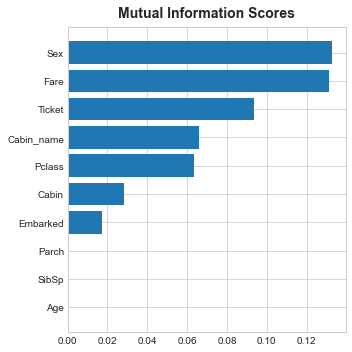

In [15]:
from sklearn.feature_selection import mutual_info_regression
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize() # it returns codes and uniques
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    discrete_features = X.dtypes == int # double check for discrete feature of integer type
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
plt.figure(figsize=(5,5))
mi_scores = make_mi_scores(Xdata.drop(labels=['Survived'],axis=1,),Xdata.Survived)
plot_mi_scores(mi_scores)

In [258]:
Xdata.corr(method='pearson')

,Survived,Age,SibSp,Parch,Fare
Survived,1.000000,-0.064910,-0.035322,0.081629,0.257307
Age,-0.064910,1.000000,-0.233296,-0.172482,0.096688
SibSp,-0.035322,-0.233296,1.000000,0.414838,0.159651
Parch,0.081629,-0.172482,0.414838,1.000000,0.216225
Fare,0.257307,0.096688,0.159651,0.216225,1.000000


In [121]:
xtrain,xvalid,ytrain,yvalid = train_test_split(Xdata.drop(labels=["Survived"],axis=1),Xdata.Survived, train_size=0.8, test_size=0.2, random_state=0)

In [122]:
ordinal_encoder = OrdinalEncoder(cols=["Pclass"] )#,mapping=mapping
label_X_train = ordinal_encoder.fit_transform(xtrain)
label_X_valid = ordinal_encoder.transform(xvalid)

In [29]:
# o_e = OrdinalEncoder(cols = "Survived")
# label_ytrain = o_e.fit_transform(ytrain)
# label_yvalid = o_e.transform(yvalid)

In [35]:
u_o = unordered_features["not_missing"] + unordered_features["missing"]

In [123]:
# some bad label columns must be removed because of them mismatch between training and validation data occurs.
good_unordered_label_cols = [col for col in u_o if set(xvalid[col]).issubset(set(xtrain[col]))]
bad_unordered_label_cols = list(set(u_o)-set(good_unordered_label_cols))
bad_unordered_label_cols
label_X_train.drop(labels=bad_unordered_label_cols,axis=1,inplace=True)
label_X_valid.drop(labels=bad_unordered_label_cols,axis=1,inplace=True)

In [124]:
#low cardinality columns
low_cardinality_cols = [col for col in good_unordered_label_cols if label_X_train[col].nunique() < 10]
# Columns that will be dropped from the dataset or can do ordinal encoding again for these high cardinality columns
high_cardinality_cols = list(set(good_unordered_label_cols)-set(low_cardinality_cols))
onehot_encoder = OneHotEncoder(cols=low_cardinality_cols)
num_X_train = onehot_encoder.fit_transform(label_X_train)
num_X_valid = onehot_encoder.transform(label_X_valid)

In [136]:
num_X_train.corr()

,Pclass,Sex_1,Sex_2,Age,SibSp,Parch,Fare,Embarked_1,Embarked_2,Embarked_3,Cabin_name_1,Cabin_name_2,Cabin_name_3,Cabin_name_4,Cabin_name_5,Cabin_name_6,Cabin_name_7,Cabin_name_8,Cabin_name_9
Pclass,1.000000,0.128916,-0.128916,0.343154,-0.093648,-0.017336,0.534776,0.222970,-0.046498,-0.227997,-0.733181,0.405809,0.364889,0.231960,-0.053291,0.240535,0.271880,-0.002162,0.059299
Sex_1,0.128916,1.000000,-1.000000,-0.092234,0.119615,0.241624,0.164523,0.078513,-0.126431,0.090761,-0.143647,0.058036,0.128091,-0.086371,0.089251,0.043882,0.078346,0.023185,-0.027333
Sex_2,-0.128916,-1.000000,1.000000,0.092234,-0.119615,-0.241624,-0.164523,-0.078513,0.126431,-0.090761,0.143647,-0.058036,-0.128091,0.086371,-0.089251,-0.043882,-0.078346,-0.023185,0.027333
Age,0.343154,-0.092234,0.092234,1.000000,-0.223819,-0.164303,0.101185,0.030401,-0.012334,-0.021770,-0.259873,0.122832,0.084474,0.135146,-0.096339,0.126344,0.153548,-0.067277,0.044665
SibSp,-0.093648,0.119615,-0.119615,-0.223819,1.000000,0.423676,0.145538,-0.061747,0.083679,-0.046896,0.053682,0.024059,-0.045330,-0.050978,-0.011193,-0.045843,-0.011605,0.013614,-0.017418
Parch,-0.017336,0.241624,-0.241624,-0.164303,0.423676,1.000000,0.213608,-0.011325,0.060159,-0.078244,-0.033103,0.048028,0.046025,-0.046205,0.074613,-0.037776,-0.010839,0.037883,-0.017904
Fare,0.534776,0.164523,-0.164523,0.101185,0.145538,0.213608,1.000000,0.249539,-0.136717,-0.123565,-0.463331,0.349690,0.395724,0.022725,-0.022387,0.039665,0.088944,-0.023966,0.002723
Embarked_1,0.222970,0.078513,-0.078513,0.030401,-0.061747,-0.011325,0.249539,1.000000,-0.771375,-0.147830,-0.186319,0.121576,0.124447,0.108734,-0.030598,-0.023137,0.083386,-0.020583,-0.017641
Embarked_2,-0.046498,-0.126431,0.126431,-0.012334,0.083679,0.060159,-0.136717,-0.771375,1.000000,-0.515356,0.073820,-0.066569,-0.061167,-0.064553,0.039667,0.045732,-0.032885,0.012433,0.022870
Embarked_3,-0.227997,0.090761,-0.090761,-0.021770,-0.046896,-0.078244,-0.123565,-0.147830,-0.515356,1.000000,0.136179,-0.060263,-0.072524,-0.046103,-0.020443,-0.039915,-0.061182,0.008396,-0.011786


In [125]:
xgb_c = XGBClassifier()
xgb_c.fit(X=num_X_train,y=ytrain)
score = xgb_c.score(X=num_X_valid,y=yvalid)
print(score)
# score_dataset_cross_val(X=xtrain,y=ytrain)

0.8379888268156425


In [131]:
find_missing(Xtdata)

[['Fare', 1, dtype('float64')],
 ['Age', 86, dtype('float64')],
 ['Cabin', 327, dtype('O')]]

3

In [132]:
Xtdata["Cabin_name"] = Xtdata.Cabin.str.extract('([A-Z]+)')
Xtdata = encode(Xtdata,unordered_features,ordered_features)

In [133]:
id_testdata = Xtdata.drop(Xtdata.columns.difference(["PassengerId"]), axis=1)

In [134]:
Xtdata.drop(labels=["PassengerId","Name"],axis=1,inplace=True)
impute_f(Xtdata,"median","Age")
# only 1 value in test data so can be imputed by directly seeing the given 3 feature (Pclass,SibSp,Parch) 
# and found out median fare price is 7.79580 
Xtdata.Fare.fillna(value=7.79580) # for test data (in training data no null value in Fare feature)
Xtdata.Cabin = Xtdata.Cabin.fillna("None")
Xtdata.Cabin_name = Xtdata.Cabin_name.fillna("None")

In [135]:
label_X_test = ordinal_encoder.transform(Xtdata)
label_X_test.drop(labels=bad_unordered_label_cols,axis=1,inplace=True)
num_X_test = onehot_encoder.transform(label_X_test)

In [119]:
survived_p = pd.DataFrame(xgb_c.predict(X=num_X_test),columns=["Survived"])

In [120]:
id_testdata.join(survived_p,how="outer").to_csv("output.csv",index=False)

In [137]:
num_X_test.corr()

,Pclass,Sex_1,Sex_2,Age,SibSp,Parch,Fare,Embarked_1,Embarked_2,Embarked_3,Cabin_name_1,Cabin_name_2,Cabin_name_3,Cabin_name_4,Cabin_name_5,Cabin_name_6,Cabin_name_7,Cabin_name_8,Cabin_name_9
Pclass,1.000000,0.108615,-0.108615,0.467853,-0.001087,-0.018721,0.577147,0.318543,-0.120783,-0.252608,-0.690579,0.454994,0.319284,0.196426,-0.042775,0.223270,0.236878,-0.018183,NaN
Sex_1,0.108615,1.000000,-1.000000,0.008035,0.099943,0.159120,0.191514,0.033684,-0.105883,0.115574,-0.131464,0.112625,0.060134,0.017617,0.064781,0.024919,0.007813,0.003300,NaN
Sex_2,-0.108615,-1.000000,1.000000,-0.008035,-0.099943,-0.159120,-0.191514,-0.033684,0.105883,-0.115574,0.131464,-0.112625,-0.060134,-0.017617,-0.064781,-0.024919,-0.007813,-0.003300,NaN
Age,0.467853,0.008035,-0.008035,1.000000,-0.071197,-0.043731,0.347105,0.162147,-0.118594,-0.041310,-0.378730,0.288973,0.178527,0.137830,-0.110376,0.085222,0.137625,-0.062330,NaN
SibSp,-0.001087,0.099943,-0.099943,-0.071197,1.000000,0.306895,0.171539,-0.016365,0.079367,-0.098824,-0.073067,0.099729,0.051938,-0.023554,0.030214,-0.000484,-0.012552,-0.030780,NaN
Parch,-0.018721,0.159120,-0.159120,-0.043731,0.306895,1.000000,0.230046,-0.005791,0.092201,-0.132948,-0.037237,-0.024072,0.107455,-0.014196,0.030356,0.041513,-0.043590,0.015341,NaN
Fare,0.577147,0.191514,-0.191514,0.347105,0.171539,0.230046,1.000000,0.312161,-0.178582,-0.155562,-0.560843,0.462959,0.418156,0.021269,-0.016618,0.131112,0.021279,-0.046463,NaN
Embarked_1,0.318543,0.033684,-0.033684,0.162147,-0.016365,-0.005791,0.312161,1.000000,-0.767375,-0.199786,-0.361643,0.230440,0.153868,0.099484,-0.027822,0.145972,0.122822,0.001945,NaN
Embarked_2,-0.120783,-0.105883,0.105883,-0.118594,0.079367,0.092201,-0.178582,-0.767375,1.000000,-0.474962,0.215525,-0.155459,-0.089376,-0.059316,0.036256,-0.096964,-0.069081,0.030397,NaN
Embarked_3,-0.252608,0.115574,-0.115574,-0.041310,-0.098824,-0.132948,-0.155562,-0.199786,-0.474962,1.000000,0.166981,-0.078703,-0.074596,-0.045892,-0.017220,-0.052164,-0.063002,-0.049120,NaN
